In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

from stable_baselines3 import A2C
from stable_baselines3.common import results_plotter
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor




# PPO

## Create Callback

In [28]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    # def _init_callback(self) -> None:
    #     # Create folder if needed
    #     if self.save_path is not None:
    #         os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

## Plot Functions

In [29]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    #y = moving_average(y, window=50)
    # Truncate x
    #x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

## Create Gif

In [30]:
import imageio
import numpy as np
from stable_baselines3 import A2C

def create_gif(env, model_path, path, name):
    model = A2C.load(model_path, env=env)
    images = []

    vec_env = model.get_env()
    obs = vec_env.reset()
    img = vec_env.render()
    for i in range(500):
        images.append(img)
        action, _ = model.predict(obs)
        obs, _, _ ,_ = vec_env.step(action)
        img = vec_env.render(mode='rgb_array')
    gif_name =  path + name + '.gif'
    imageio.mimsave(gif_name, [np.array(img) for i, img in enumerate(images) if i%2 == 0], duration=120)

## Normal parameters

In [31]:
# Create environment
env = gym.make("CarRacing-v2")

In [32]:
#setup callback

# Create log dir
log_dir = "a2c_normal/"
os.makedirs(log_dir, exist_ok=True)

# Wrap the environment
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

### Train agent

In [33]:
# Instantiate the agent
#model = PPO("MlpPolicy", env, verbose=1)
model = A2C("MlpPolicy", env, verbose=1)
# Train the agent and display a progress bar
timesteps = 10000
model.learn(total_timesteps=int(timesteps), callback=callback)


Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
------------------------------------
| time/                 |          |
|    fps                | 30       |
|    iterations         | 100      |
|    time_elapsed       | 16       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.25    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.73     |
|    std                | 0.997    |
|    value_loss         | 2.36     |
------------------------------------
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -72.51
Saving new best model to a2c_normal/best_model.zip
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -72.5    |
| time/                 |          |
|    fps                | 30      

In [34]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)

In [35]:
print(mean_reward, std_reward)

-93.3097544 0.5029659276339142


In [36]:
# Helper from the library
#results_plotter.plot_results(
 #   [log_dir], timesteps, results_plotter.X_TIMESTEPS, "A2C CarRacing-v2"
#)

In [37]:
#plot_results(log_dir)

### Load pre-trained model

In [38]:
test_env = gym.make("CarRacing-v2", render_mode='human')
dir = os.path.join(log_dir, "best_model.zip")
model = A2C.load(dir, env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [39]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()

In [40]:
test_env = gym.make("CarRacing-v2", render_mode='rgb_array')
dir = os.path.join(log_dir, "best_model")
create_gif(test_env, dir, log_dir, "a2c_car")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


## Discrete space

In [41]:
# Create environment
env = gym.make("CarRacing-v2", continuous=False)

In [42]:
#setup callback

# Create log dir
log_dir = "a2c_discrete/"
os.makedirs(log_dir, exist_ok=True)

# Wrap the environment
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

### Train agent

In [52]:
# Instantiate the agent
model = A2C("MlpPolicy", env, verbose=1)
# Train the agent and display a progress bar
timesteps = 10000
model.learn(total_timesteps=int(timesteps), callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
------------------------------------
| time/                 |          |
|    fps                | 30       |
|    iterations         | 100      |
|    time_elapsed       | 16       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.37    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00878 |
|    value_loss         | 4.76e-05 |
------------------------------------
Num timesteps: 1000
Best mean reward: -62.83 - Last mean reward per episode: -85.89
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1e+03     |
|    ep_rew_mean        | -72.9     |
| time/                 |           |
|    fps                | 26        |
|    iterations         | 200       |
|    time_elapsed       | 38        |
|

In [53]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)

In [54]:
print(mean_reward, std_reward)

-93.26666739999999 0.2900716381562324


In [46]:
# Helper from the library
#results_plotter.plot_results(
 #   [log_dir], timesteps, results_plotter.X_TIMESTEPS, "A2C CarRacing-v2"
#)

In [47]:
#plot_results(log_dir)

### Load pre-trained model

In [55]:
test_env = gym.make("CarRacing-v2", render_mode='human', continuous=False)
dir = os.path.join(log_dir, "best_model.zip")
model = A2C.load(dir, env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [49]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()

In [56]:
test_env = gym.make("CarRacing-v2", render_mode='rgb_array', continuous=False)
dir = os.path.join(log_dir, "best_model")
create_gif(test_env, dir, log_dir, "a2c_car")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


## Lap completion percentage change 

In [57]:
# Create environment
env = gym.make("CarRacing-v2", lap_complete_percent=0.5)

In [58]:
#setup callback

# Create log dir
log_dir = "_lap/"
os.makedirs(log_dir, exist_ok=True)

# Wrap the environment
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

### Train agent

In [65]:
# Instantiate the agent
model = A2C("MlpPolicy", env, verbose=1)
# Train the agent and display a progress bar
model.learn(total_timesteps=int(10000),callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
------------------------------------
| time/                 |          |
|    fps                | 32       |
|    iterations         | 100      |
|    time_elapsed       | 15       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.27    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00624 |
|    std                | 1        |
|    value_loss         | 3.21e-06 |
------------------------------------
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -77.58
Saving new best model to _lap/best_model.zip
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -67.6    |
| time/                 |          |
|    fps                | 28       |
|  

In [66]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)

In [67]:
print(mean_reward, std_reward)

-83.15073220000001 0.6707502729130722


In [ ]:
# Helper from the library
#results_plotter.plot_results(
 #   [log_dir], timesteps, results_plotter.X_TIMESTEPS, "A2C CarRacing-v2"
#)

In [ ]:
#plot_results(log_dir)

### Load pre-trained model

In [69]:
test_env = gym.make("CarRacing-v2", render_mode='human',)# continuous=False)
dir = os.path.join(log_dir, "best_model.zip")
model = A2C.load(dir, env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [70]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()

In [71]:
test_env = gym.make("CarRacing-v2", render_mode='rgb_array')
dir = os.path.join(log_dir, "best_model")
create_gif(test_env, dir, log_dir, "a2c_car")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


## Train with CNN instead of MLP

In [72]:
env = gym.make("CarRacing-v2", render_mode = "rgb_array")

In [73]:
#setup callback

# Create log dir
log_dir = "a2c_cnn/"
os.makedirs(log_dir, exist_ok=True)

# Wrap the environment
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [80]:
# Instantiate the agent
model = A2C("CnnPolicy", env, verbose=1)
# Train the agent and display a progress bar
timesteps = 10000
model.learn(total_timesteps=int(timesteps), callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
------------------------------------
| time/                 |          |
|    fps                | 31       |
|    iterations         | 100      |
|    time_elapsed       | 15       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.26    |
|    explained_variance | 0.759    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0258   |
|    std                | 1        |
|    value_loss         | 9.12e-05 |
------------------------------------
Num timesteps: 1000
Best mean reward: -80.89 - Last mean reward per episode: -81.92
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -74.2    |
| time/                 |          |
|    fps                | 28       |
|    iterations         | 200      |
|    time

In [81]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)

print(mean_reward, std_reward)

-93.20874360000002 0.6813822410663796


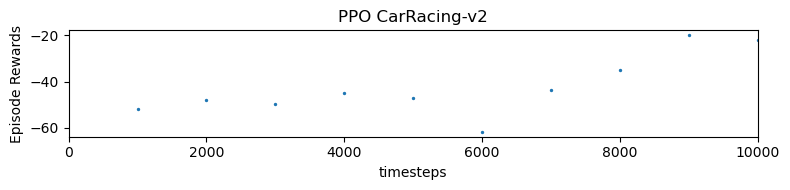

In [ ]:
# Helper from the library
#results_plotter.plot_results(
 #   [log_dir], timesteps, results_plotter.X_TIMESTEPS, "A2C CarRacing-v2"
#)

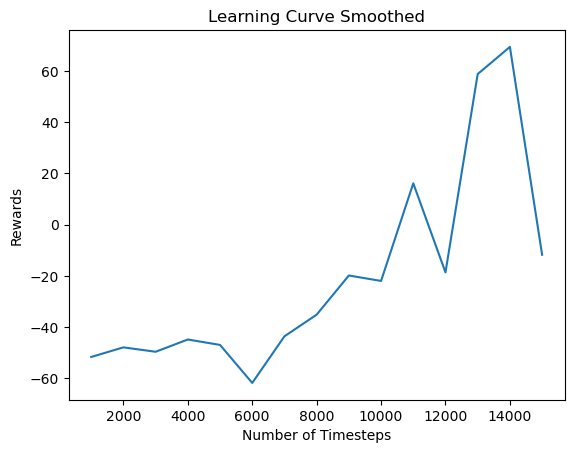

In [ ]:
#plot_results(log_dir)

## Load pre-trained model

In [82]:
test_env = gym.make("CarRacing-v2", render_mode='human')
dir = os.path.join(log_dir, "best_model.zip")
model = A2C.load(dir, env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
vec_env = model.get_env()
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, info = vec_env.step(action)
    #obs, rewards, dones, info = test_env.step(action)
    vec_env.render()
    if done:
        break

vec_env.close()

In [83]:
test_env = gym.make("CarRacing-v2", render_mode='rgb_array')
dir = os.path.join(log_dir, "best_model")
create_gif(test_env, dir, log_dir, "a2c_car")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
